## Categorical Perception: A Groundwork for Deep Learning
#### Laurent Bonnasse-Gahot & Jean-Pierre Nadal
Python notebook for reproducing the results presented in Section 3.2.2, Figure 4 (Changes in the neural representation following learning of categories).

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

# for reproducibility
SEED = 1
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rc={'font.size': 11, 'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.set_style('ticks')

In [2]:
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
import matplotlib.ticker as plticker

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

from sklearn import decomposition

In [3]:
if not os.path.exists('fig'):
    os.makedirs('fig')

In [4]:
n_classes = 10

(x_train, y_train), (x_test, y_test) =  mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

input_shape = (np.prod(x_train.shape[1:]),)

In [5]:
batch_size = 128
n_epochs = 50
n_hid = 256

input_x = Input(shape=input_shape)
x = Dense(n_hid, activation='relu')(input_x)
x = Dropout(0.2)(x)
x = Dense(n_hid, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(n_classes, activation='softmax')(x)
model = Model(input_x, x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_init = tf.keras.models.clone_model(model)
model_init.set_weights(model.get_weights())
model_init.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))), 
          tf.keras.utils.to_categorical(y_train, n_classes),
          batch_size=batch_size,
          epochs=n_epochs,
          validation_data=(x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))),
                           tf.keras.utils.to_categorical(y_test, n_classes)),
          verbose=1)

Epoch 1/50
469/469 [==============================] - 2s 4ms/step - loss: 0.5824 - accuracy: 0.8250 - val_loss: 0.1189 - val_accuracy: 0.9637
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 0.1480 - accuracy: 0.9570 - val_loss: 0.0935 - val_accuracy: 0.9699
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0991 - accuracy: 0.9700 - val_loss: 0.0727 - val_accuracy: 0.9764
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0736 - accuracy: 0.9760 - val_loss: 0.0694 - val_accuracy: 0.9768
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0606 - accuracy: 0.9812 - val_loss: 0.0685 - val_accuracy: 0.9796
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0509 - accuracy: 0.9831 - val_loss: 0.0635 - val_accuracy: 0.9793
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0470 - accuracy: 0.9840 - val_loss: 0.0679 - val_accuracy: 0.9799
Epoch 

In [6]:
encoder = load_model('model/mnist_encoder_cnn.h5')
decoder = load_model('model/mnist_decoder_cnn.h5')

In [7]:
n_test = x_test.shape[0]

In [8]:
encoded_imgs = encoder(x_test).numpy()

In [9]:
def get_continuum(encoded_imgs, k1, k2, n):
    act1 = encoded_imgs[k1]
    act2 = encoded_imgs[k2]
    alpha_rg = np.linspace(0.,1.,n)
    img_continuum = []
    act_alpha = []
    for alpha in alpha_rg:
        act_alpha.append((1-alpha)*act1 + alpha*act2)
    img_continuum = decoder(np.array(act_alpha)).numpy()
    return img_continuum

def cosine_distance(act1, act2):
    return (1 - np.dot(act1, act2)/(np.linalg.norm(act1)*np.linalg.norm(act2)))

In [10]:
idx_4 = np.flatnonzero(y_test == 4)
idx_9 = np.flatnonzero(y_test == 9)
idx_not49 = np.setdiff1d(np.arange(y_test.size), np.concatenate((idx_4, idx_9)))

# in order to have a better mix between dots
# when plotting each elements of the categories
idx49 = np.concatenate((idx_4, idx_9))
idx49_col = np.concatenate((np.zeros(len(idx_4)), np.ones(len(idx_9)))).astype(int)
randperm = np.random.permutation(idx49.size)
color = np.array(['tab:blue', 'tab:red'])

In [11]:
n_morphs = 16
k1, k2 = 19, 12
img_continuum = get_continuum(encoded_imgs, k1, k2, n_morphs)
pmux = model(img_continuum.reshape(n_morphs, -1)).numpy()[:,[y_test[k1], y_test[k2]]]

In [12]:
n_layers = 2

In [13]:
def compute_representation(model):
    hidden_layers = [layer for layer in model.layers 
                     if layer.name.startswith('dense')][:-1]
    hidden_outputs = [layer.output for layer in hidden_layers]
    activation_model = Model(inputs=model.input, outputs=hidden_outputs)

    activation_layers = activation_model(x_test.reshape(n_test, -1))
    activation_layers_morph = activation_model(img_continuum.reshape(n_morphs, -1))

    data_pca = []
    morph_pca = []
    for activation_layer, activation_layer_morph in zip(activation_layers, activation_layers_morph):
        pca = decomposition.PCA(random_state=SEED)
        pca.n_components = 2
        data_pca.append(pca.fit_transform(activation_layer))
        morph_pca.append(pca.transform(activation_layer_morph))

    neural_distance_layers = [[cosine_distance(activation_layer_morph[i], activation_layer_morph[i+1])
                               for i in range(n_morphs-1)]
                              for activation_layer_morph in activation_layers_morph]
    
    return data_pca, morph_pca, neural_distance_layers

In [14]:
data_pca_init, morph_pca_init, neural_distance_layers_init = compute_representation(model_init)
data_pca, morph_pca, neural_distance_layers = compute_representation(model)

In [15]:
ylim_cp = (-0.05, 1.05)
min_dist = np.min([neural_distance_layers_init, neural_distance_layers])
max_dist = np.max([neural_distance_layers_init, neural_distance_layers])
ylim_nd = (min_dist-0.1*(max_dist-min_dist), max_dist+0.1*(max_dist-min_dist))

def plot_results(model, data_pca, morph_pca, neural_distance_layers, title):
    fh, axes = plt.subplots(4, n_layers, figsize=(8, 10), gridspec_kw={'height_ratios': [3, 3, 0.2, 2]})
    fh.suptitle(title, fontweight='bold', fontsize=14)
    for i in range(n_layers):
        fh.axes[i].set_title('hidden layer {}'.format(i+1), fontsize=14)

        #========== top row ==========
        # 2d pca projections based on the activations of the hidden layers on the test
        # only plot one every four data points in order to lighten the figure
        axes[0,i].scatter(data_pca[i][idx_not49,0][::4], 
                          data_pca[i][idx_not49,1][::4],
                          alpha=0.1, color='0.5', s=20, edgecolor='None')
        axes[0,i].scatter(data_pca[i][idx49[randperm],0][::4], 
                          data_pca[i][idx49[randperm],1][::4],
                          alpha=0.4, color=color[idx49_col[randperm]][::4], 
                          s=20, edgecolor='None')
        # plot the 4 to 9 continuum
        for k, img in enumerate(img_continuum):
            imgtmp = np.repeat(1-img, 4, axis=2)#.astype('uint8')
            imgtmp[:,:,-1] = 1 - imgtmp[:,:,-1]
            imgtmp[:,:,-1][imgtmp[:,:,-1]>0.4] = 1
            ab = AnnotationBbox(OffsetImage(imgtmp, zoom=0.2),
                                morph_pca[i][k], 
                                frameon=False, annotation_clip=False)
            axes[0,i].add_artist(ab)    
        axes[0,i].set_xticklabels(labels='')
        axes[0,i].xaxis.set_major_locator(plticker.MultipleLocator(base=2.0))
        axes[0,i].set_yticklabels(labels='')
        axes[0,i].yaxis.set_major_locator(plticker.MultipleLocator(base=2.0))

        #========== middle row ==========
        # zoom on the 4 to 9 continuum
        # 2d pca projections based on the activations of the hidden layers on the test
        # do not plot outside bounds, otherwise dots will be present in the pdf even though not visible    
        xmin, ymin = np.min(morph_pca[i], axis=0)
        xmax, ymax = np.max(morph_pca[i], axis=0) 
        xmin, xmax = xmin - 0.1*(xmax-xmin), xmax + 0.1*(xmax-xmin)
        ymin, ymax = ymin - 0.1*(ymax-ymin), ymax + 0.1*(ymax-ymin)
        axes[1,i].scatter(np.ma.masked_outside(data_pca[i][idx_not49,0], xmin, xmax),
                   np.ma.masked_outside(data_pca[i][idx_not49,1], ymin, ymax),
                   alpha=0.05, color='0.5', s=20, edgecolor='None')
        axes[1,i].scatter(np.ma.masked_outside(data_pca[i][idx49[randperm],0], xmin, xmax), 
                   np.ma.masked_outside(data_pca[i][idx49[randperm],1], ymin, ymax),
                   alpha=0.3, color=color[idx49_col[randperm]], s=20, edgecolor='None')
        # plot the 4 to 9 continuum
        for k, img in enumerate(img_continuum):
            imgtmp = np.repeat(1-img, 4, axis=2)
            imgtmp[:,:,-1] = 1 - imgtmp[:,:,-1]
            ab = AnnotationBbox(OffsetImage(imgtmp, zoom=1.0),
                                morph_pca[i][k], 
                                frameon=False, annotation_clip=False)
            axes[1,i].add_artist(ab)
        axes[1,i].axis((xmin, xmax, ymin, ymax))
        axes[1,i].set_xticklabels(labels='')
        axes[1,i].xaxis.set_major_locator(plticker.MultipleLocator(base=2.0))
        axes[1,i].set_yticklabels(labels='')
        axes[1,i].yaxis.set_major_locator(plticker.MultipleLocator(base=2.0))
        axes[0,0].set_ylabel('pc2')
        axes[1,0].set_ylabel('pc2')
        axes[1,0].set_xlabel('pc1')
        axes[1,1].set_xlabel('pc1')

        # blank space
        axes[2,i].set_visible(False)

        #========== bottom row ========== 
        # posterior probabilities from the network along the continuum
        # neural distance between adjacent items along the continuum
        axes[3,i].plot(np.arange(n_morphs), pmux[:,0], color='tab:blue', ls='--', lw=2)
        axes[3,i].plot(np.arange(n_morphs), pmux[:,1], color='tab:red', ls='--', lw=2)
        axtmp = axes[3,i].twinx()
        axtmp.plot(.5+np.arange(n_morphs-1), neural_distance_layers[i], '-', color='0.2', lw=2)
        axes[3,i].set_xticklabels(labels='')
        axes[3,i].set_yticklabels(labels='')
        axtmp.set_yticklabels(labels='')
        axes[3,i].set_xlabel('4-9 continuum')
        axes[3,i].set_ylim(ylim_cp)
        axtmp.set_ylim(ylim_nd)    
    fh.axes[-4].set_ylabel('categorical prediction')
    fh.axes[-1].set_ylabel('neural distance')

    plt.show()
    
    return fh

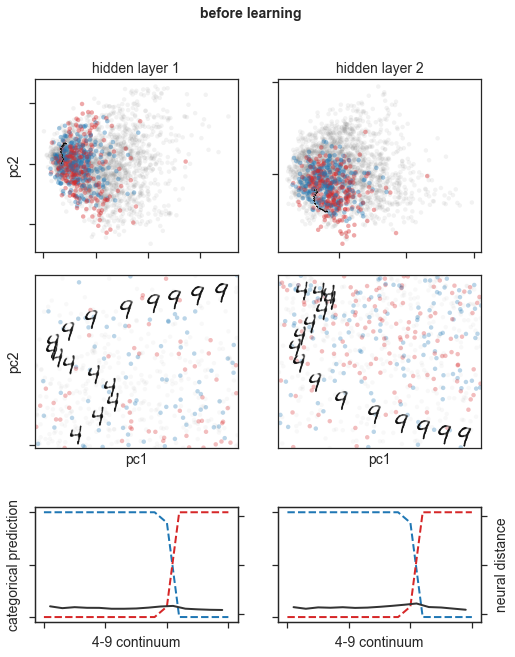

In [16]:
fh = plot_results(model_init, data_pca_init, morph_pca_init, neural_distance_layers_init, 'before learning')
fh.savefig('fig/mnist_4_9_example_before_learning.pdf', bbox_inches='tight')

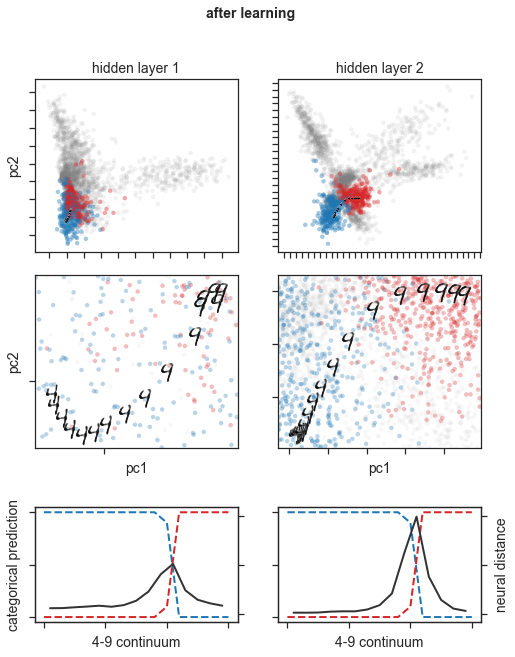

In [17]:
fh = plot_results(model, data_pca, morph_pca, neural_distance_layers, 'after learning')
fh.savefig('fig/mnist_4_9_example_after_learning.pdf', bbox_inches='tight')